In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pyro
import pyro.optim
import pyro.distributions as dist
from scipy.stats import pearsonr
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from antibody_design.src.utils import load_seqs, encode, make_splits
from bb_opt.src.bayesian_opt import (
    optimize_inputs, bnn_predict,
    make_bnn_model, make_guide,
    normal_priors, normal_variationals    
)
from bb_opt.src.utils import random_points, plot_contours

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pyro.enable_validation()  # slower but better for debugging
%matplotlib inline


class Flatten(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.view(x.shape[0], -1)

nn.Flatten = Flatten

# Ab Model

In [2]:
tasks = ['J3/J2']
mask_val = -999

seqs = load_seqs(tasks, mask_val)
seqs.head()

,J3/J2
seq,
HKPQAKSNLPYRILDY,0.364144
GDYYDIGVVPWDTFDY,0.556030
DPHDGDDFDY,-1.680760
RSKHYWHPSTTRYFDY,-1.755724
DVVLYSSAGQYSDTSFDV,0.033151


In [20]:
splits = make_splits(seqs.index, seqs[tasks], test_frac=.5, val_frac=0, by_value=False)
max_seq_len = splits.train.inputs.str.len().max()

for split in splits:
    if len(splits[split].inputs):
        splits[split].inputs = encode(splits[split].inputs.str.pad(max_seq_len, side='right', fillchar='J'))
#         splits[split].inputs = get_prot_vecs(splits[split].inputs, max_seq_len)

splits.train.inputs.shape

(14824, 20, 20)

In [21]:
_, n_features, n_timesteps = splits.train.inputs.shape
cnn_kernels = 64
pool_stride = 2
dense_size = 32

model = nn.Sequential(
    nn.Conv1d(n_features, cnn_kernels, 5, padding=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(cnn_kernels * n_timesteps, dense_size),
    nn.ReLU(),
#     nn.Dropout(),
    nn.Linear(dense_size, 1)
).to(device)

In [22]:
train_inputs = torch.tensor(splits.train.inputs).float().to(device)
train_labels = torch.tensor(splits.train.labels.values).float().to(device)

In [23]:
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

train_inputs = torch.tensor(splits.train.inputs).float().to(device)
train_labels = torch.tensor(splits.train.labels.values).float().to(device)
train_data = TensorDataset(train_inputs, train_labels)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

val_inputs = torch.tensor(splits.val.inputs).float().to(device)
val_labels = torch.tensor(splits.val.labels.values).float().to(device)
val_data = TensorDataset(val_inputs, val_labels)
val_loader = DataLoader(val_data, batch_size=256)

In [7]:
for epoch in range(10):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        predictions = model(inputs)
        loss = loss_func(predictions, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = []
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            predictions = model(inputs)
            val_loss.append(loss_func(predictions, labels))
        val_loss = np.mean(val_loss)        

    print(f'[E{epoch}] Loss = {loss.item():.3f}. Val loss = {val_loss.item():.3f}')

[E0] Loss = 0.287. Val loss = 0.307
[E1] Loss = 0.284. Val loss = 0.282
[E2] Loss = 0.273. Val loss = 0.269
[E3] Loss = 0.265. Val loss = 0.263
[E4] Loss = 0.251. Val loss = 0.258
[E5] Loss = 0.318. Val loss = 0.254
[E6] Loss = 0.237. Val loss = 0.258
[E7] Loss = 0.258. Val loss = 0.254
[E8] Loss = 0.203. Val loss = 0.256
[E9] Loss = 0.192. Val loss = 0.259


In [8]:
def jointplot(*args, **kwargs):
    ax = sns.jointplot(*args, **kwargs, s=5, alpha=0.3)
    ax.set_axis_labels('Predicted', 'Actual')

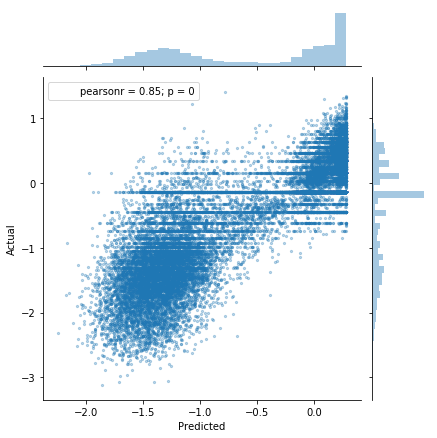

In [9]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        predictions = model(inputs)
        all_preds.append(np.array(predictions))
        all_labels.append(np.array(labels))
    torch.cuda.empty_cache()

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
jointplot(all_preds, all_labels)

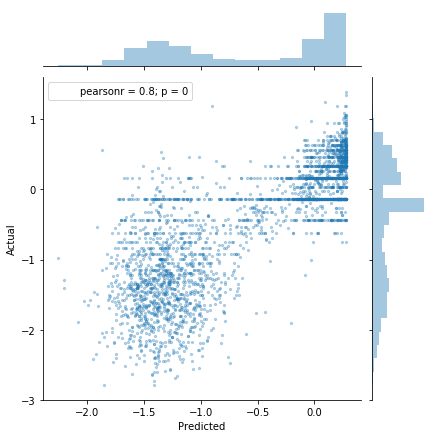

In [10]:
with torch.no_grad():
    preds = np.array(model(torch.tensor(splits.test.inputs).float().to(device)))
    torch.cuda.empty_cache()

jointplot(preds, splits.test.labels.values)

In [13]:
params = []
for name, param in model.named_parameters():
    params.append(np.array(param.detach()))

params = np.concatenate([p.ravel() for p in params])

print(np.mean(params), np.std(params), len(params))
del params

-0.00060971366 0.045105074 47489


# BNN

In [24]:
prior_mean = 0
prior_std = .05
batch_size = 128

In [25]:
def get_corr(guide, inputs, labels, n_samples: int, plot: bool=False):
    all_preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            nn_sample = guide()  # guide doesn't need input data
            nn_sample.eval()
            all_preds.append(np.array(nn_sample(inputs)))
    all_preds = np.concatenate(all_preds, axis=1)
    mean_preds = all_preds.mean(axis=1)
    
    if plot:
        jointplot(mean_preds, labels)

    corr = pearsonr(mean_preds, labels)[0]
    return corr

def train(svi, n_steps: int, train_inputs, train_labels, verbose: bool=False):
    losses = []
    train_corrs = []
    val_corrs = []

    for step in range(n_steps):
        loss = svi.step(train_inputs, train_labels)
        losses.append(loss)
        if step % 500 == 0:
            train_corr = get_corr(guide, train_inputs, train_labels.squeeze(), n_samples=50)
#             val_corr = get_corr(guide, val_inputs, splits.val.labels.values.squeeze(), n_samples=50)
            train_corrs.append(train_corr)
#             val_corrs.append(val_corr)
            
            if verbose:
                print(f"[S{step:04}] loss: {loss:,.0f}; t_corr: {train_corr:.3f}")#"; v_corr: {val_corr:.3f}")
    return losses, train_corrs#, val_corrs

In [26]:
optimizer = pyro.optim.Adam({})

priors = lambda: normal_priors(model, prior_mean, prior_std)
variational_dists = lambda: normal_variationals(model, prior_mean, prior_std)

bnn_model = make_bnn_model(model, priors, batch_size=batch_size)
guide = make_guide(model, variational_dists)

In [27]:
pyro.clear_param_store()
svi = pyro.infer.SVI(bnn_model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

losses = []
train_corrs = []
# val_corrs = []

In [28]:
train_inputs = torch.tensor(splits.train.inputs).float().to(device)
train_labels = torch.tensor(splits.train.labels.values).float().to(device)

In [32]:
res = train(svi, 10000, train_inputs, train_labels, verbose=True)
losses += res[0]
train_corrs += res[1]
# val_corrs += res[2]

[S0000] loss: 313,728; t_corr: 0.755
[S0500] loss: 205,851; t_corr: 0.751
[S1000] loss: 129,923; t_corr: 0.745
[S1500] loss: 84,493; t_corr: 0.744
[S2000] loss: 58,656; t_corr: 0.732
[S2500] loss: 42,755; t_corr: 0.729
[S3000] loss: 36,785; t_corr: 0.726
[S3500] loss: 31,445; t_corr: 0.731
[S4000] loss: 30,718; t_corr: 0.729
[S4500] loss: 23,573; t_corr: 0.734
[S5000] loss: 22,051; t_corr: 0.734
[S5500] loss: 20,782; t_corr: 0.737
[S6000] loss: 19,917; t_corr: 0.743
[S6500] loss: 18,707; t_corr: 0.745
[S7000] loss: 18,632; t_corr: 0.744
[S7500] loss: 17,978; t_corr: 0.747
[S8000] loss: 17,765; t_corr: 0.752
[S8500] loss: 17,954; t_corr: 0.751
[S9000] loss: 17,653; t_corr: 0.751
[S9500] loss: 17,487; t_corr: 0.753


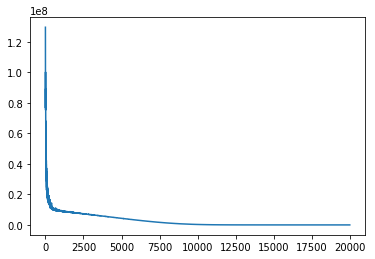

In [33]:
plt.plot(losses)

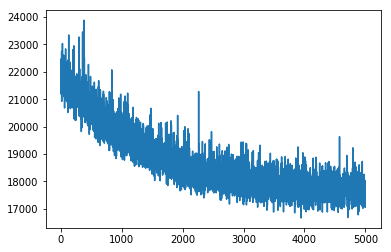

In [34]:
plt.plot(losses[-5000:])

There never seems to be any overfitting, which is nice; we can train the model as long as we want (until the validation performance hasn't improved for some time?).

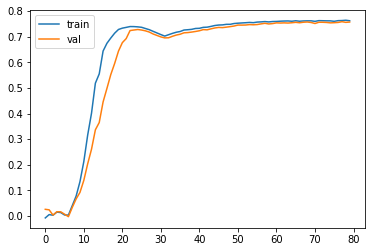

In [54]:
plt.plot(train_corrs, label='train')
plt.plot(val_corrs, label='val')
plt.legend()

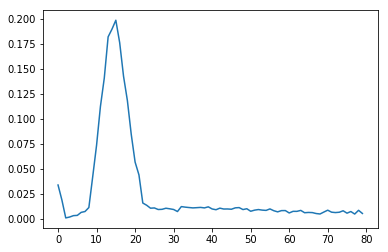

In [51]:
plt.plot(abs(np.array(train_corrs) - np.array(val_corrs)))

In [30]:
test_inputs = torch.tensor(splits.test.inputs).float().to(device)

In [31]:
preds = bnn_predict(guide, test_inputs, n_samples=1000)

In [20]:
from scipy.stats import pearsonr

In [32]:
correlations = [pearsonr(preds[i], splits.test.labels.values.squeeze())[0] for i in range(len(preds))]

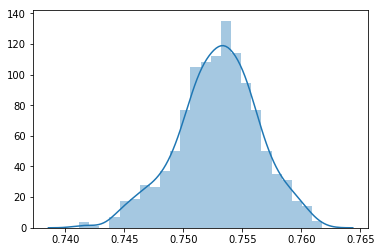

In [33]:
sns.distplot(correlations)

In [75]:
import pandas as pd

Text(0.5,0,'# Standard Deviations')

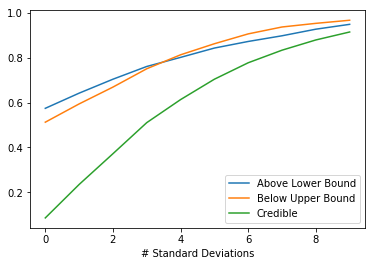

In [114]:
def count_credible(preds, labels, std_coeff: float):
    mean = np.mean(preds, axis=0)
    std = np.std(preds, axis=0)
    credible_bounds = (mean - std_coeff * std, mean + std_coeff * std)
    above_lower = (credible_bounds[0] <= labels)
    below_upper = (labels <= credible_bounds[1])
    credible = (above_lower & below_upper)
    n_above_lower = above_lower.sum()
    n_below_upper = below_upper.sum()
    n_credible = credible.sum()
    n_total = len(splits.test.labels)
    return n_above_lower, n_below_upper, n_credible, n_total

df = pd.DataFrame([count_credible(preds, splits.test.labels.values.squeeze(), std_coeff=i) for i in np.linspace(.5, 8, num=10)])
df.columns = ['Above Lower Bound', 'Below Upper Bound', 'Credible', 'n_total']

n_total = df.n_total.values
df = df.drop('n_total', axis=1)
df = df.apply(lambda col: col / n_total, axis=0)

df.plot()
plt.xlabel('# Standard Deviations')

In [118]:
i = 0

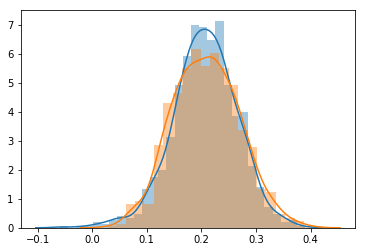

In [145]:
mean = preds[:, i].mean()
std = preds[:, i].std()
sns.distplot(preds[:, i])
sns.distplot(np.random.normal(loc=mean, scale=std, size=1000))
i += 1

KDE doesn't work well because we sometimes get likelihoods of zero.

In [165]:
i = 90
stats.gaussian_kde(preds[:, i]).pdf(labels[i]), labels[i]

(array([0.]), array([-2.78242692]))

In [167]:
log_likelihood = 0
log_likelihood_kde = 0
labels = splits.test.labels.values
for i in range(len(labels)):
    mean = preds[:, i].mean()
    std = preds[:, i].std()
    log_likelihood += np.log(stats.norm.pdf(labels[i], loc=mean, scale=std))[0]
    log_likelihood_kde += np.log(stats.gaussian_kde(preds[:, i]).pdf(labels[i]))[0]
#     print(i, np.log(stats.gaussian_kde(preds[:, i]).pdf(labels[i]))[0])
print(-log_likelihood / len(labels))
print(-log_likelihood_kde / len(labels))

/cluster/nhunt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


9.770806565408227
inf


In [116]:
from scipy import stats

In [156]:
pdf = 

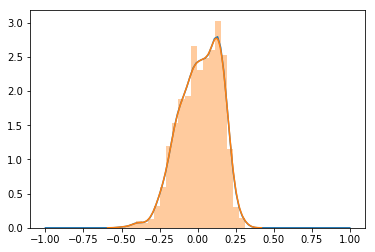

In [159]:
x = np.linspace(-1, 1, 100)
plt.plot(x, pdf.pdf(x))
sns.distplot(preds[:, i])

In [171]:
np.e ** -9.77

5.7140352049861084e-05

/cluster/nhunt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


nan

In [ ]:
# standardize labels?

### Optimizing Input

Should I try using the ProtVecs as input instead? That space is continuous, at least.
  * For decoding, do this in a smart way that uses the overlap of the kmers; instead of just decoding the first vector to a 3-mer, consider how compatible the two residues that overlap with the 3-mer for the second vector are. E.g. if the first vector is closest to SRG but the second is closest to AGT, and the 3rd is closest to SQW, we have
  SRG
   AGT
    SQW
  and we need to decide what we do at the locations that don't agree.
  * I think we should formulate the decoding as a dynamic programming problem somehow; try to find the sequence whose total (Euclidean) distance (when embedded as a protvec) is closest to the actual protvecs we have (instead of doing a greedy decoding).
* Maybe compare one-hot vs protvec (and also different decoding methods for each? e.g. project back to seq space every step for one-hot vs project back every $k$ vs only at the end) in terms of the predicted affinity of the sequence we get after decoding the optimized input

In [337]:
nn_sample = guide()
nn_sample

Sequential(
  (0): Conv1d(20, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (1): ReLU()
  (2): Flatten()
  (3): Linear(in_features=1280, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=1, bias=True)
)

In [339]:
inputs = train_inputs[1:5].clone().requires_grad_()
input_opt = torch.optim.Adam([inputs])

In [328]:
def update_inp():
    # TODO: constrain input in some way here
    input_opt.zero_grad()
    output = nn_sample(inp)
    # don't know if we should need `retain_graph`; there might
    # be something better I should be doing... 
    (-output).backward(torch.ones_like(output))
    return output

In [332]:
inp.grad

In [ ]:
input_opt.zero_grad()

In [333]:
output = nn_sample(inp)
# don't know if we should need `retain_graph`; there might
# be something better I should be doing... 
(-output).backward(torch.ones_like(output))

In [335]:
inp.grad.shape

torch.Size([4, 20, 20])

In [329]:
outputs = []
for _ in range(10000):
    outputs.append(input_opt.step(update_inp).detach().cpu().numpy())
outputs = np.concatenate(outputs, axis=1)

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [ ]:
plt.plot(outputs[0])

In [316]:
inp[0:1].argmax(dim=1)

tensor([[ 12,  11,  19,  13,  18,  18,  10,  19,   2,  19,   4,  10,
           1,  12,  18,  12,  15,   4,   5,  16]], device='cuda:0')

In [ ]:
inp.argmax()

### Variance vs # NN Samples

How does the variance in the predictive distribution for a given input change as we use more models?
  * It seems that the mean variance first goes up (which you expect because there can't be much variance with only a couple of models) and then levels off (at the "true" value, or at least what we think it is).
  * 500 models seem sufficient to get the proper variance reproducibly.

In [135]:
n_samples = [2, 5, 10, 25, 50, 100, 250, 500, 1000, 1500, 2000, 5000]
mean_vars = []
n_repeats = 3

with torch.no_grad():
    for n in n_samples:
        mean_var = []
        for rep in range(n_repeats):
            preds = []
            for _ in range(n):
                nn_sample = guide()
                nn_sample.eval()
                preds.append(np.array(nn_sample(val_inputs)))
            preds = np.array(preds).squeeze().T
            mean_var.append(preds.var(axis=1).mean())
        mean_vars.append(mean_var)

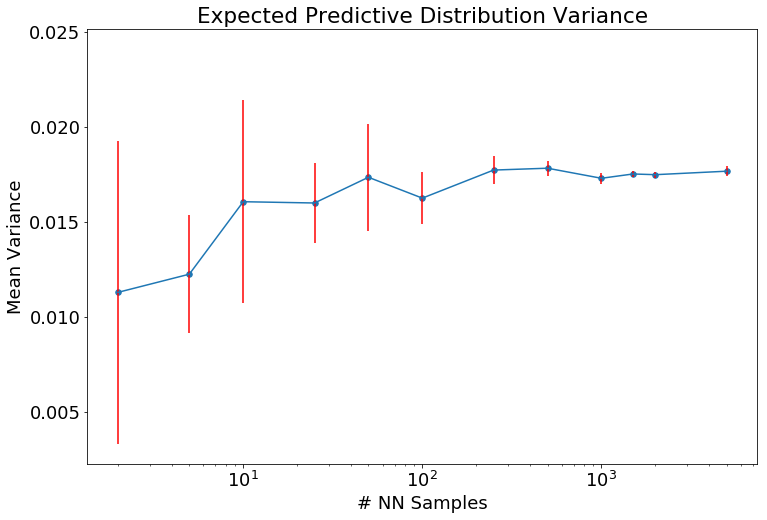

In [171]:
plt.figure(figsize=(12, 8))
plt.rc('font', size=18)
plt.scatter(n_samples, [np.mean(repeats) for repeats in mean_vars], s=30)
plt.plot(n_samples, [np.mean(repeats) for repeats in mean_vars])
plt.errorbar(n_samples, [np.mean(repeats) for repeats in mean_vars],
             [2 * np.std(repeats) for repeats in mean_vars],
             linestyle="None", c='red')
plt.xscale('log')
plt.xlabel('# NN Samples')
plt.ylabel('Mean Variance')
plt.title('Expected Predictive Distribution Variance');

### Posterior Predictive Distributions

Are the posterior predictive distributions always monotonic?
  * Yes, that seems to be the case.

In [179]:
preds = []
with torch.no_grad():
    for _ in range(500):
        nn_sample = guide()
        nn_sample.eval()
        preds.append(np.array(nn_sample(val_inputs)))
preds = np.array(preds).squeeze().T

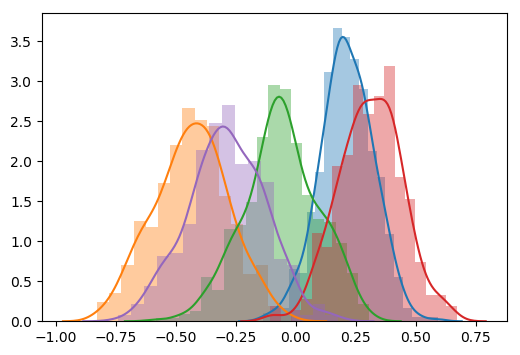

In [215]:
plt.figure(figsize=(6, 4))
[sns.distplot(preds[i]) for i in np.random.randint(len(preds), size=5)];

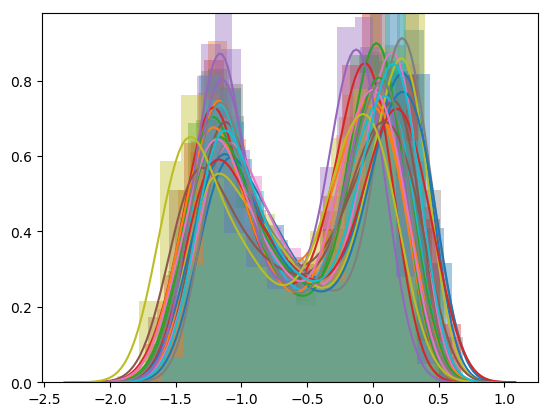

In [182]:
# you can also look at the overall affinity distribution of each sampled model
# and see how those compare

[sns.distplot(preds.T[i]) for i in np.random.randint(len(preds.T), size=20)];

# Model Saving / Loading Testing
Make convenience functions for these things; probably start some pytorch utils file.

In [29]:
ps = pyro.get_param_store()
ps

In [32]:
ps.save('models/params')

In [33]:
optimizer.save('models/opt')

In [ ]:
pyro.module()

In [ ]:
pyro.random_module()

In [ ]:
ps.save()

In [ ]:
save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.arch,
            'model_state': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer_state' : optimizer.state_dict(),
        }, is_best)

def save_checkpoint(state, is_best, fname='checkpoint.pth.tar'):
    torch.save(state, fname)
    if is_best:
        shutil.copyfile(fname, 'model_best.pth.tar')

if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))